## Predicting Mutation Effects

We aim to compute the following function:

$$
S_{\text{masked marginal}} = \sum_{i \in M} \left[ \log p(x_i = x_{i}^{\text{mt}}|x_{-M}) - \log p(x_i = x_{i}^{\text{wt}}|x_{-M}) \right]
$$

The masked_marginal_scoring function calculates the change in the log probability of observing a mutated amino acid sequence, given the rest of the protein sequence, compared to the original (wild-type) sequence. This function leverages a language model trained on protein sequences to generate predictions for the probability of each amino acid at specific positions, given the context of the surrounding sequence.

Reference: [Language models enable zero-shot prediction of the effects of mutations on protein function](https://www.biorxiv.org/content/10.1101/2021.07.09.450648v2)

In [ ]:
!pip install transformers torch
!pip install "fair-esm[esmfold]"

**1- Load the ESM2 model and tokenizer**

The smaller models are suitable for various sequence and token classification tasks. The  Facebook AI Research (FAIR) team also adapted the 3 Billion parameter version into the ESMFold protein structure prediction algorithm.

In [ ]:
from transformers import AutoTokenizer, EsmForMaskedLM

# Load the ESM2 model and tokenizer
model_name = "facebook/esm2_t33_650M_UR50D"
#model_name ="facebook/esm2_t36_3B_UR50D" #this model is large for the google collab
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = EsmForMaskedLM.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

**2 - Generate Mutated Sequences**

In [ ]:
# Example protein sequence with a masked amino acid
enzyme_seq_string = "MKYKKLFETVKIRNVELKNRYAMAPMGPLGLADAEGGFNQRGIEYYTARARGGTALIITGVTFVDNEVEEHGMPNVPCPTHNPVHFVRTSKEMTERIHAYDSKIFLQMSAGFGRVTIPTNLGEYPPVAPSPIPHRWLDKTCRELTVEEIHSIVRKFGDGAFNAKRAGFDGVQIHAVHEGYLLDQFAIAFFNKRTDAYGGPLENRLRFAREIVEEIKQRCGEDFPVTLRFSPKSFIKDWREGALPGEEFEEKGRDLDEGIEAAKLLVSYGYDALDVDVGSYDSWWWSHPPMYQKKGLYIPYARLVKEAVDVPVLCAGRMDNPDLALAALEDGACDIISLGRPLLADPDYVNKLRIGQVADIRPCLSCHEGCMGRIQEYSSLGCAVNPAACREKEAALTPALKKKRVLIAGGGVAGCEAARVLASRGHEPVIFEKSNRLGGNLIPGGAPDFKEDDLALVAWYEHTLERLGVEIHLNTALTKEEILAANVDAVLIATGSNPKILPLDGKNKVFTAEDVLLDKVDAGQHVVIVGGGLVGCELALNLAEKGKDVSLVEMQDKLLAVNGPLCHANSDMLERLVPFKGVQVYTSSKIVDTTEKTAVVDVDGELREIEADSIVLAVGYSAEKSLYEDLKFEVADLHVVGDARKVANIMYAIWDAYEVAANL"
original_sequence = list(enzyme_seq_string)

# Mask a specific amino acid (e.g., the 3th, 4th amino acid)
masked_sequences = []
mutate_index = [25, 26,  27, 28, 59, 60, 111, 116, 177, 275, 279, 282, 285, 286, 296, 366, 369, 370, 373]
# mutate_index = [25, 27]

# for index in mutate_index:
#   print(original_sequence[index])

for position in mutate_index:
    temp = original_sequence[position]
    original_sequence[position] = tokenizer.mask_token #<mask>
    masked_sequence = "".join(original_sequence)
    masked_sequences.append(masked_sequence)
    original_sequence[position] = temp #restore the original amino acid

print(f"Original Sequence: {original_sequence}")
print(f"Masked Sequences: {masked_sequences}")


NameError: name 'tokenizer' is not defined

**3 - Calculating the prob distribution over amino-acids in masked location**

In [ ]:
import torch
# Tokenize the input sequences
inputs = tokenizer(masked_sequences, return_tensors="pt")
print(inputs)
print("masked token id: ", tokenizer.mask_token_id)
# Get the logits for the masked positions
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits

print(logits.size())

{'input_ids': tensor([[ 0, 20, 15,  ..., 17,  4,  2],
        [ 0, 20, 15,  ..., 17,  4,  2],
        [ 0, 20, 15,  ..., 17,  4,  2],
        ...,
        [ 0, 20, 15,  ..., 17,  4,  2],
        [ 0, 20, 15,  ..., 17,  4,  2],
        [ 0, 20, 15,  ..., 17,  4,  2]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])}
masked token id:  32


In [ ]:
# Get the index of the masked position
mask_token_index = (inputs["input_ids"] == tokenizer.mask_token_id).nonzero(as_tuple=True)
print(f"Masked Position Index: {mask_token_index}")

Masked Position Index: (tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18]), tensor([ 26,  27,  28,  29,  60,  61, 112, 117, 178, 276, 280, 283, 286, 287,
        297, 367, 370, 371, 374]))


In [ ]:
# Get the logits for the masked position
mask_token_logits = logits[mask_token_index[0], mask_token_index[1], :]
print(mask_token_logits.size())

torch.Size([19, 33])


In [ ]:
from torch.nn import functional as F
# Convert logits to probabilities
probabilities = F.softmax(mask_token_logits, dim=-1)

# Get the distribution over the amino acids
amino_acid_distributions = []
for probability in probabilities:
  amino_acid_distributions.append({tokenizer.decode([i]): prob.item() for i, prob in enumerate(probability)})

# Print the distribution
for i, distribution in enumerate(amino_acid_distributions):
    print(f"Predicted Distribution @ index {mutate_index[i]}:")
    print(distribution)
# print("Predicted Distribution:")
# for aa, prob in amino_acid_distribution.items():
#     print(f"{aa}: {prob:.4f}")

#plot the distribution



Predicted Distribution @ index 25:
{'<cls>': 5.115460943727612e-09, '<pad>': 2.284593304466287e-12, '<eos>': 1.5731015379216728e-09, '<unk>': 2.6528245745949253e-12, 'L': 0.006191424559801817, 'A': 0.002335956320166588, 'G': 0.00013578230573330075, 'V': 0.011934658512473106, 'S': 0.0006946174544282258, 'E': 4.909508061246015e-05, 'R': 6.747812585672364e-05, 'T': 0.006412798073142767, 'I': 0.011654496192932129, 'D': 1.1220996384508908e-05, 'P': 2.2877105948282406e-05, 'K': 9.662035154178739e-05, 'Q': 0.000489270780235529, 'N': 0.00018924276810139418, 'F': 0.0007866121013648808, 'Y': 9.48716260609217e-05, 'M': 0.9584506154060364, 'H': 0.00012398528633639216, 'W': 2.7236081223236397e-05, 'C': 0.00022902831551618874, 'X': 1.8075829757435713e-06, 'B': 2.486380656918641e-09, 'U': 2.0536650424674008e-07, 'Z': 6.209135428036916e-09, 'O': 4.3920050929457943e-10, '.': 2.8506969007580096e-10, '-': 5.263826041712605e-10, '<null_1>': 6.318410794570184e-10, '<mask>': 2.5238799765403552e-12}
Predicte

In [ ]:
import matplotlib.pyplot as plt

def plot_distribution(amino_acid_distribution):
  # Plot the distribution with different colors for each bar
  special_tokens = {'<pad>', '<unk>', '<cls>', '<sep>', '<mask>', '<eos>', '.', '<null_1>', '-'}
  filtered_distribution = {aa: prob for aa, prob in amino_acid_distribution.items() if aa not in special_tokens}

  amino_acids = list(filtered_distribution.keys())
  probs = list(filtered_distribution.values())

  # Create a colormap for coloring each bar differently
  colors = plt.cm.get_cmap('Dark2', len(amino_acids))

  plt.figure(figsize=(7, 3))
  bars = plt.bar(amino_acids, probs, color=colors(range(len(amino_acids))))
  plt.ylabel('Probability')
  plt.xticks(rotation=90)
  # plt.title(f'Mutation @ {mask_token_index}')
  plt.tight_layout()

  plt.show()

Predicted Distribution @ index 25/ position 26 - original letter: M 


<ipython-input-11-7304e22145b4>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Dark2', len(amino_acids))


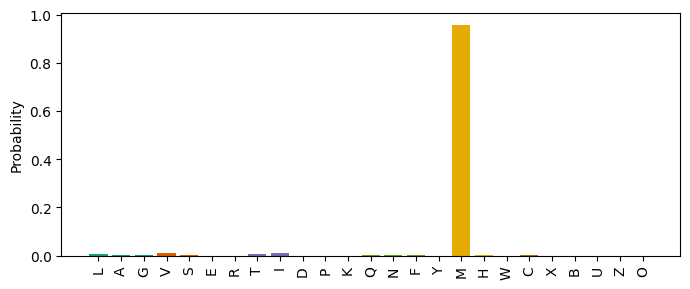

Predicted Distribution @ index 26/ position 27 - original letter: G 


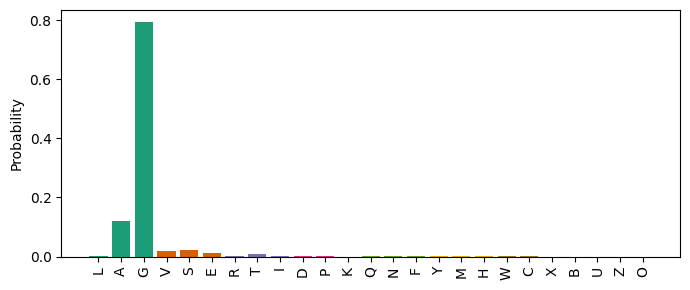

Predicted Distribution @ index 27/ position 28 - original letter: P 


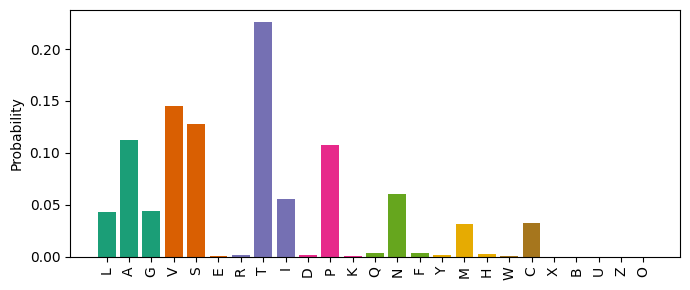

Predicted Distribution @ index 28/ position 29 - original letter: L 


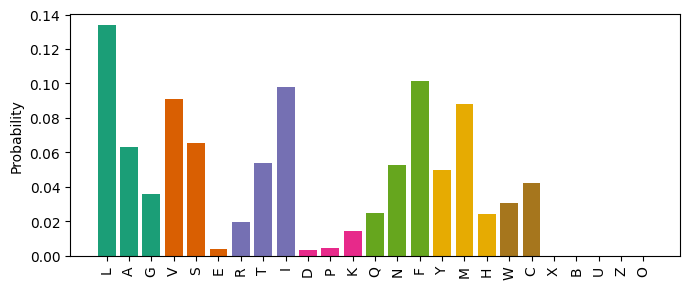

Predicted Distribution @ index 59/ position 60 - original letter: G 


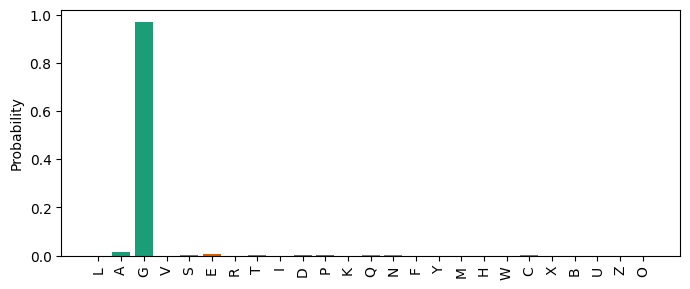

Predicted Distribution @ index 60/ position 61 - original letter: V 


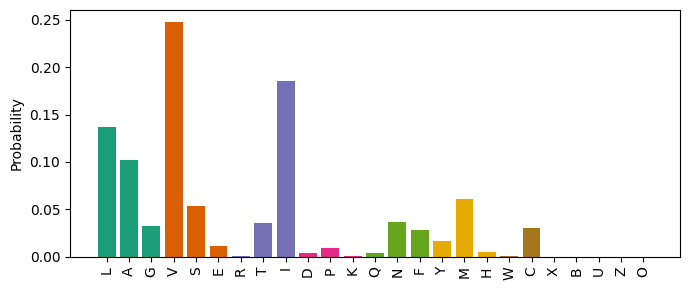

Predicted Distribution @ index 111/ position 112 - original letter: F 


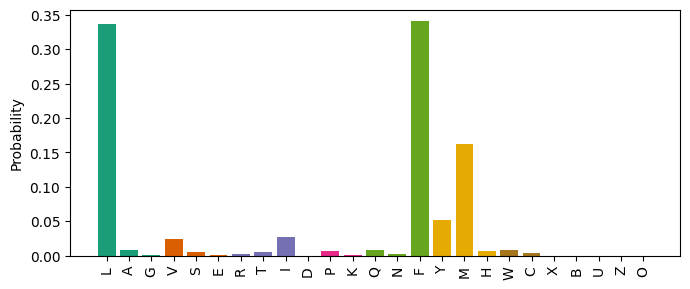

Predicted Distribution @ index 116/ position 117 - original letter: I 


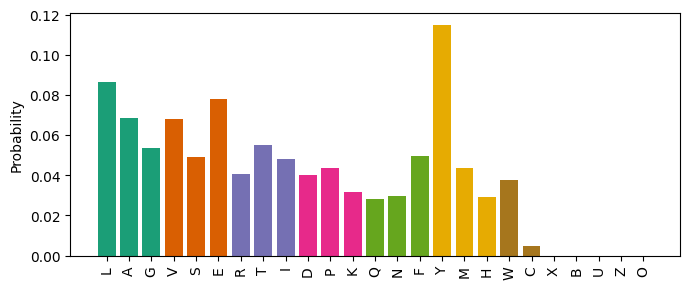

Predicted Distribution @ index 177/ position 178 - original letter: E 


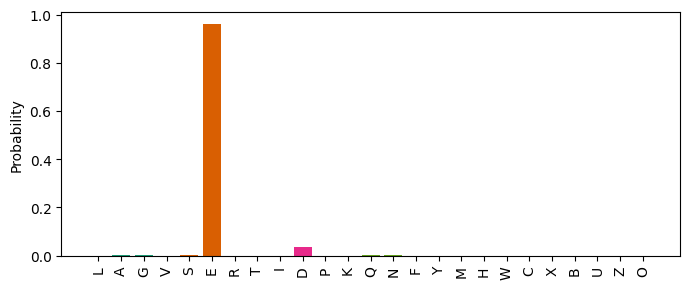

Predicted Distribution @ index 275/ position 276 - original letter: D 


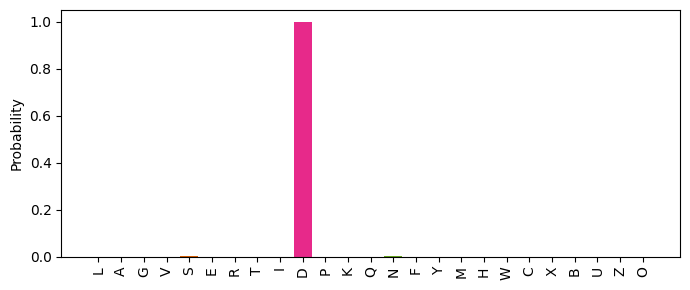

Predicted Distribution @ index 279/ position 280 - original letter: Y 


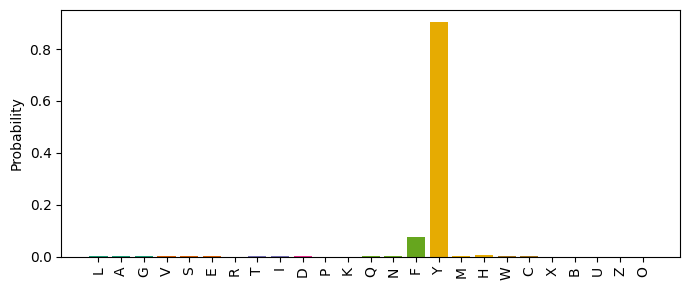

Predicted Distribution @ index 282/ position 283 - original letter: W 


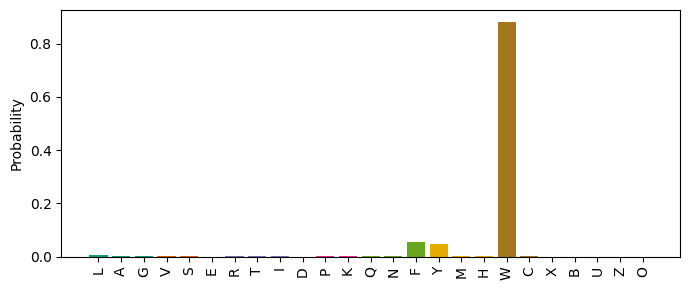

Predicted Distribution @ index 285/ position 286 - original letter: S 


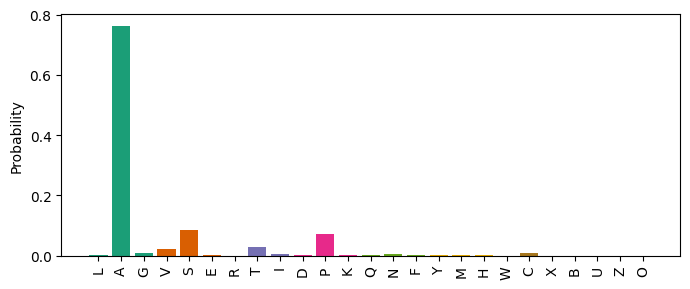

Predicted Distribution @ index 286/ position 287 - original letter: H 


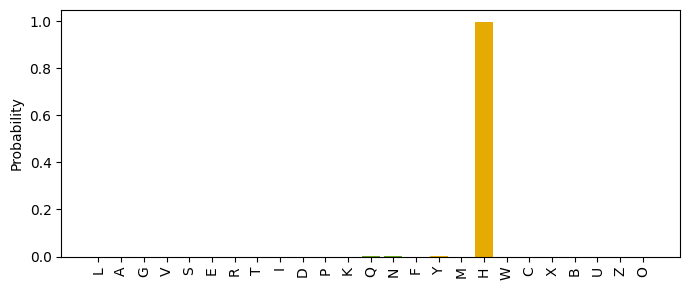

Predicted Distribution @ index 296/ position 297 - original letter: Y 


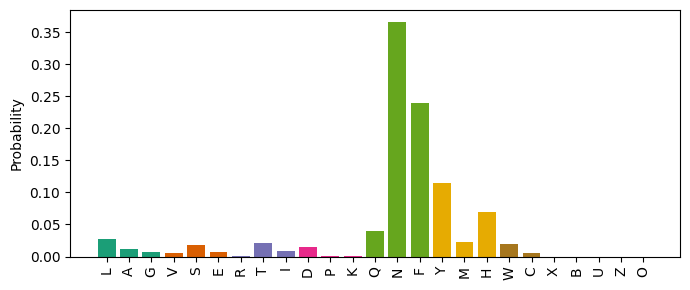

Predicted Distribution @ index 366/ position 367 - original letter: H 


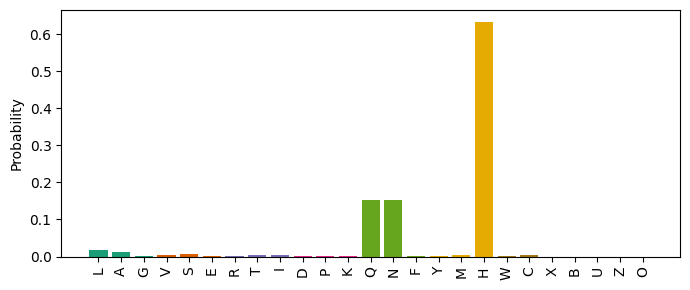

Predicted Distribution @ index 369/ position 370 - original letter: C 


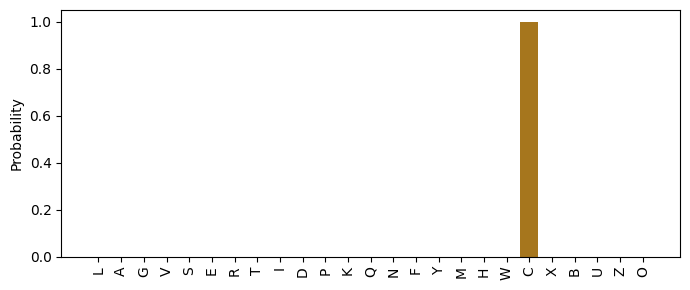

Predicted Distribution @ index 370/ position 371 - original letter: M 


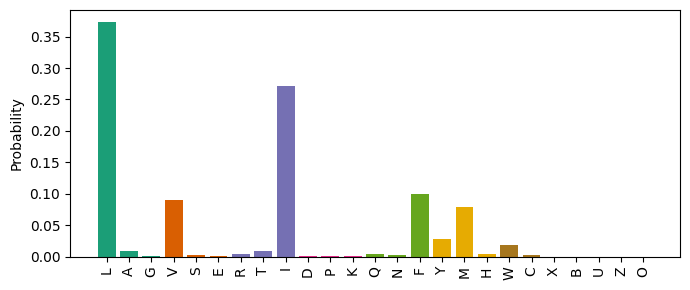

Predicted Distribution @ index 373/ position 374 - original letter: I 


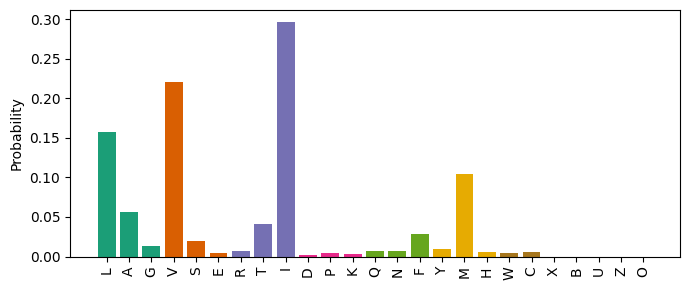

In [ ]:
# Print the distribution
for i, distribution in enumerate(amino_acid_distributions):
    print("==================================================")
    print(f"Predicted Distribution @ index {mutate_index[i]}/ position {mutate_index[i] + 1} - original letter: {original_sequence[mutate_index[i]]} ")
    plot_distribution(distribution)